# Assignment 3: Cluster Analysis
### GDAA 2010 Data Mining Modeling
### April 8, 2022
### By Juan C. Reyes and Rachel Thevenard
### Faculty: Dr. Steven Edwards
---

# Assignment Purpose

Cluster analysis is an unsupervised machine learning task that involves discovering natural grouping in data. Clustering can be useful for pattern discovery or knowledge discovery.

The purpose of this assignment is to apply clustering algorithms in Python to investigate the performance of each model on the data. 

# Data

The dataset chosen was a collection of demographic and spending data pertaining to 6,588 Dissemination Areas (DA's) making up the Greater Montreal area. The DA's were downloaded from Statistics Canada and clipped to the Greater Montreal area using ArcGIS Pro. ArcGIS Pro's Business Analyst extension was used to enrich the layer with 2021 demographic and spending data. 

The target variable of choice was "Pop Single (Never Married): Percent", consisting of the percentage of the population in each dissemination area who have never married or lived in a common-law relationship. 

The data projection is NAD 1983 Lambert Conformal Conic.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import math
import matplotlib.pyplot as plt
from minisom import MiniSom
import contextily as cx
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import seaborn as sns
pd.set_option("display.max_columns", None)

In [2]:
gdf = gpd.read_file('GreaterMTL_DAs.shp')

## Data Visualization

Text(0.5, 1.0, '2021 Percentage of Population Single (Never Married) in Greater Montreal')

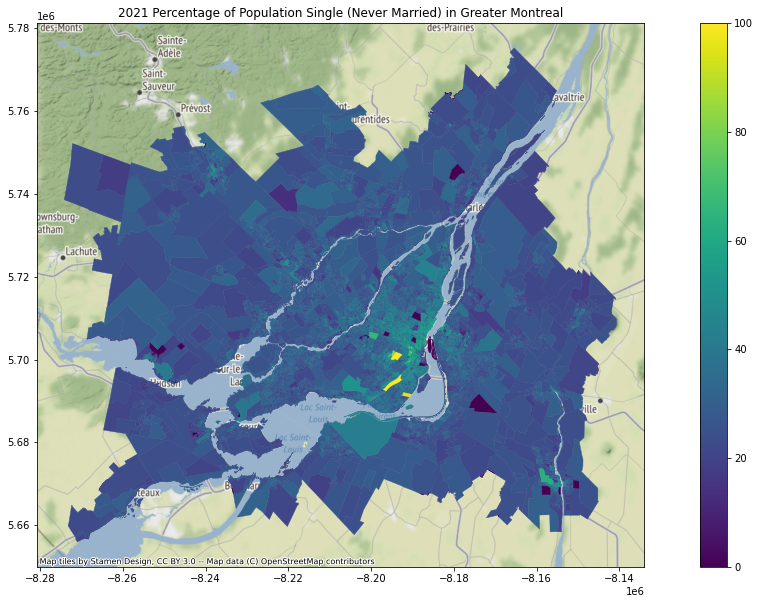

In [3]:
gdf_wm = gdf.to_crs(epsg=3857)
ax = gdf_wm.plot('maritals_5', figsize=(20,10), legend=True, edgecolor="face", linewidth=0.4)
cx.add_basemap(ax)
ax.set_title('2021 Percentage of Population Single (Never Married) in Greater Montreal')

# Data Cleaning and Preparation

We import the names for all of our columns, as well as define the names of columns which will be used for the predictor matrix.

In [4]:
# Ensure that the columns have the long form name 
gdf.columns = ['DAUID', 'DGUID', 'LANDAREA', 'PRUID', 'aggregationMethod',
       'HasData', 'ORIGINAL_OID', 'sourceCountry',
       '2021 HHs Exp:Tot Expenditure', '2021 Health Care',
       '2021 HHs Exp:Tot Cur Consumptn', '2021 Male Median Age',
       '2021 Total Pop Median Age', '2021 Female Median Age',
       '2021 Total Population', '2026 Total Population',
       '2021 Daytime Pop Total Pop', '2016 HH Type - Total HHs (Census)',
       '2021 HH Type: Total Family HHs', '2026 HH Type: Total Family HHs',
       '2021 Tenure: Total HHs', '2021 Tenure: Owned',
       '2021 Tenure: Owned: Percent', '2021 Tenure: Rented',
       '2021 Tenure: Rented: Percent', '2021 Edu 15+ Above Bachelor',
       '2021 Edu 15+ Above Bachelor: Percent', '2021 Edu 15+ < Bachelor',
       '2021 Edu 15+ < Bachelor: Percent', '2021 Edu 15+ College Dipl',
       '2021 Edu 15+ College Dipl: Percent', '2021 Labour Force HH Pop 15+',
       '2021 Not In the Labour Force', '2021 Not In the Labour Force: Percent',
       '2021 Occ: HH Pop 15+', '2021 Pop Married or Common-Law',
       '2021 Pop Married or Common-Law: Percent', '2021 Pop Living Common Law',
       '2021 Pop Living Common Law: Percent',
       '2021 Pop Single (Never Married)',
       '2021 Pop Single (Never Married): Percent', '2021 OL: English Only',
       '2021 OL: English Only: Percent', '2021 MT: English',
       '2021 MT: English: Percent', '2021 MT: French',
       '2021 MT: French: Percent', '2021 Total PRIZM HHs',
       '2021 Total PRIZM POP', '2021 Dom PRIZM Number',
       '2021 Total Population.1', '2021 Daytime Pop Total Pop.1',
       '2021 HH Inc: Median Curr$', '2021 Transportation',
       '2021 Transportation: Percent', '2021 Tot Charitable Contrib',
       '2021 Goods/Svcs: Internet', '2021 Lawn/Snow/Garbage Removal',
       '2021 Pet Expenses', '2021 Food Purch From Restaurants',
       '2021 Food Purch From Stores', 'Shape_Length', 'Shape_Area', 'Geometry']

In [5]:
# Variables of interest:
predictors = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]

In [6]:
gdf[predictors].describe()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
count,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00
mean,65.06,270559.03,130222.30,2315293.07,1024146.83,46.40,292.63,98.24,156.41,120.77,42.01,84109.34,78078.73,119753.60,177.52
std,25.83,338880.32,137715.20,1812711.42,943107.53,79.41,219.58,71.19,147.97,122.73,7.84,40665.99,138738.92,402103.21,117.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,43.59,108673.65,61531.04,1494472.29,590607.61,5.00,194.00,61.00,77.00,21.00,37.50,57048.25,10900.24,30867.23,117.00
50%,71.53,187425.56,95387.30,1848078.30,781184.92,16.00,243.00,83.00,131.00,98.00,41.70,75016.78,39532.69,49567.61,155.00
75%,88.06,306244.05,147353.23,2461543.20,1114267.58,59.00,313.00,112.00,184.00,184.00,45.80,100704.65,94552.66,89954.18,203.00
max,100.00,6374261.01,2293405.77,31955283.22,18648179.72,1624.00,3324.00,1136.00,2124.00,1575.00,86.00,300001.00,5247461.03,15934557.86,2905.00


There are no null values.

In [7]:
gdf[predictors].head()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
0,97.16,259692.98,230003.98,3235064.56,1684293.68,6.00,466.00,116.00,291.00,37.00,46.20,95909.09,154903.64,47867.83,230.00
1,97.32,194574.97,157908.20,2299650.20,982041.77,1.00,325.00,104.00,211.00,13.00,40.50,96363.64,103392.87,27072.50,137.00
2,95.59,109902.22,103585.43,1615943.20,783150.76,0.00,250.00,64.00,141.00,15.00,39.20,100000.00,86379.76,15987.94,81.00
3,98.56,311271.17,198084.48,3103804.59,1398573.69,0.00,480.00,108.00,306.00,0.00,38.70,97049.18,115075.43,36557.51,194.00
4,96.55,141014.08,136061.06,2025840.51,987458.26,2.00,295.00,73.00,184.00,30.00,41.80,92903.23,107546.42,17902.51,189.00


In [8]:
# Replace zero values with null values
gdf[predictors] = gdf[predictors].replace(0, np.nan)
# Fill null values with mean values of each column
gdf[predictors] = gdf[predictors].apply(lambda x: x.fillna(x.mean()), axis=0)

In [9]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(gdf[predictors])
pd.DataFrame(data_scaled, columns = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]).describe()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
count,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.50,-0.81,-0.95,-1.29,-1.10,-0.67,-1.35,-1.39,-1.09,-1.19,-3.71,-1.63,-0.57,-0.30,-1.52
25%,-0.84,-0.48,-0.50,-0.46,-0.46,-0.57,-0.45,-0.53,-0.54,-0.74,-0.66,-0.68,-0.49,-0.22,-0.52
50%,0.24,-0.25,-0.25,-0.26,-0.26,-0.31,-0.23,-0.21,-0.17,-0.01,-0.07,-0.23,-0.27,-0.18,-0.20
75%,0.89,0.10,0.12,0.07,0.09,0.08,0.08,0.18,0.16,0.41,0.50,0.40,0.11,-0.07,0.21
max,1.37,18.05,15.75,16.44,18.76,20.29,13.89,14.69,13.46,12.57,6.25,5.38,37.30,39.34,23.36


# Applying Sturge's Rule

Sturge's Rule is used to select the optimal number of bins in a histogram. This equation will be used to derive the optimal number of clusters.

### Formula:
k = 1 + 3.322 log n  
Where:  
k = the number of bins    
n = the number of observations in the dataset

In [10]:
# Number of observations in the dataset
n = len(gdf[predictors])
n

6588

In [11]:
k = 1 + 3.322*math.log(n)

In [12]:
k

30.210362913290396

In [13]:
bins = math.floor(k)

In [14]:
bins

30

In [15]:
# Define the cluster range
clusters = range(29, 32)

In [16]:
for c in clusters:
    print(c)

29
30
31


# Kohonen network model

Kohonen artifical neural networks or Kohonen maps is a type of Artificial Neural Networks (ANNs). It is an unsupervised learning method and data visualization technique, and it is often called a Self-Organizing Map, or SOM. 

[More information on Kohonen Network Models](https://www.analyticsvidhya.com/blog/2021/09/beginners-guide-to-anomaly-detection-using-self-organizing-maps/)

Implementing SOM's is possible through the use of the Minisom library (https://github.com/sethns/Self-Organizing-Maps). We begin by importing the library in order to work with it:


In [17]:
from minisom import MiniSom

To be safe, we reload the data from above and bin target variables into classes to let us visualize the clustering later on.

In [18]:
gdf = gpd.read_file('GreaterMTL_DAs.shp')

# Ensure that the columns have the long form name 
gdf.columns = ['DAUID', 'DGUID', 'LANDAREA', 'PRUID', 'aggregationMethod',
       'HasData', 'ORIGINAL_OID', 'sourceCountry',
       '2021 HHs Exp:Tot Expenditure', '2021 Health Care',
       '2021 HHs Exp:Tot Cur Consumptn', '2021 Male Median Age',
       '2021 Total Pop Median Age', '2021 Female Median Age',
       '2021 Total Population', '2026 Total Population',
       '2021 Daytime Pop Total Pop', '2016 HH Type - Total HHs (Census)',
       '2021 HH Type: Total Family HHs', '2026 HH Type: Total Family HHs',
       '2021 Tenure: Total HHs', '2021 Tenure: Owned',
       '2021 Tenure: Owned: Percent', '2021 Tenure: Rented',
       '2021 Tenure: Rented: Percent', '2021 Edu 15+ Above Bachelor',
       '2021 Edu 15+ Above Bachelor: Percent', '2021 Edu 15+ < Bachelor',
       '2021 Edu 15+ < Bachelor: Percent', '2021 Edu 15+ College Dipl',
       '2021 Edu 15+ College Dipl: Percent', '2021 Labour Force HH Pop 15+',
       '2021 Not In the Labour Force', '2021 Not In the Labour Force: Percent',
       '2021 Occ: HH Pop 15+', '2021 Pop Married or Common-Law',
       '2021 Pop Married or Common-Law: Percent', '2021 Pop Living Common Law',
       '2021 Pop Living Common Law: Percent',
       '2021 Pop Single (Never Married)',
       '2021 Pop Single (Never Married): Percent', '2021 OL: English Only',
       '2021 OL: English Only: Percent', '2021 MT: English',
       '2021 MT: English: Percent', '2021 MT: French',
       '2021 MT: French: Percent', '2021 Total PRIZM HHs',
       '2021 Total PRIZM POP', '2021 Dom PRIZM Number',
       '2021 Total Population.1', '2021 Daytime Pop Total Pop.1',
       '2021 HH Inc: Median Curr$', '2021 Transportation',
       '2021 Transportation: Percent', '2021 Tot Charitable Contrib',
       '2021 Goods/Svcs: Internet', '2021 Lawn/Snow/Garbage Removal',
       '2021 Pet Expenses', '2021 Food Purch From Restaurants',
       '2021 Food Purch From Stores', 'Shape_Length', 'Shape_Area', 'Geometry']

# Variables of interest:
predictors = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]


# Bin the "Never Married" population into equal categories of low, medium, and high
labels = ['Low', 'Medium', 'High']
gdf['Single_Bin'] = pd.qcut(gdf['2021 Pop Single (Never Married)'], q=3, labels=labels)

#Create a data dictionary which attributes a numerical class to a string 
dictionary = {
    0: 'Low',
    1: 'Medium',
    2: 'High'
}


#dictionary containing  target names to index value
inverted_dict = dict(map(reversed, dictionary.items()))

#Invert the classification 
gdf = gdf.replace({'Single_Bin': inverted_dict})

#create a new target vector column with the contents of the population of single individuals
target = gdf["Single_Bin"]
#create a dataframe containing the predictor columns only
df = gdf[predictors]


# Display the first five rows of our data

In [19]:
df.head()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
0,97.16,259692.98,230003.98,3235064.56,1684293.68,6.00,466.00,116.00,291.00,37.00,46.20,95909.09,154903.64,47867.83,230.00
1,97.32,194574.97,157908.20,2299650.20,982041.77,1.00,325.00,104.00,211.00,13.00,40.50,96363.64,103392.87,27072.50,137.00
2,95.59,109902.22,103585.43,1615943.20,783150.76,0.00,250.00,64.00,141.00,15.00,39.20,100000.00,86379.76,15987.94,81.00
3,98.56,311271.17,198084.48,3103804.59,1398573.69,0.00,480.00,108.00,306.00,0.00,38.70,97049.18,115075.43,36557.51,194.00
4,96.55,141014.08,136061.06,2025840.51,987458.26,2.00,295.00,73.00,184.00,30.00,41.80,92903.23,107546.42,17902.51,189.00


# Display the target variable as a column vector.

*Note:* This target variable is not used in the Kohonen network, given that the network is an unsupervised algorithm (there is no back-propagation). However, we can use labeled classes in order to visuallize how each row of data is being clustered in the final layer of the network.

In [20]:
target

0       1
1       0
2       0
3       2
4       1
       ..
6583    0
6584    1
6585    2
6586    0
6587    0
Name: Single_Bin, Length: 6588, dtype: category
Categories (3, int64): [0 < 1 < 2]

# Data cleaning and standardizing

In [21]:
# Replace zero values with null values
df = df.replace(0, np.nan)
# Fill null values with mean values of each column
df = df.apply(lambda x: x.fillna(x.mean()), axis=0)

In [22]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pd.DataFrame(df_scaled, columns = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]).describe()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
count,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.50,-0.81,-0.95,-1.29,-1.10,-0.67,-1.35,-1.39,-1.09,-1.19,-3.71,-1.63,-0.57,-0.30,-1.52
25%,-0.84,-0.48,-0.50,-0.46,-0.46,-0.57,-0.45,-0.53,-0.54,-0.74,-0.66,-0.68,-0.49,-0.22,-0.52
50%,0.24,-0.25,-0.25,-0.26,-0.26,-0.31,-0.23,-0.21,-0.17,-0.01,-0.07,-0.23,-0.27,-0.18,-0.20
75%,0.89,0.10,0.12,0.07,0.09,0.08,0.08,0.18,0.16,0.41,0.50,0.40,0.11,-0.07,0.21
max,1.37,18.05,15.75,16.44,18.76,20.29,13.89,14.69,13.46,12.57,6.25,5.38,37.30,39.34,23.36


# Our data is ready to be fed into the Kohonen Network.

One last thing, note from the Minisom documentations (https://github.com/JustGlowing/minisom) that our data has to be input into the artificial neural network as a numpy matrix where each element is a real number and each row corresponds to an observation. So, even though we have been working with pandas data frames for the convenience of data cleaning and manipulation, we continue forward with the numpy array df_scaled, which contains all of our data as a 'list of lists', with each list element containing each row of the pandas data frame.

Let's take a quick look at what this numpy array looks like:

In [23]:
df_scaled

array([[ 1.25420460e+00, -3.81414210e-02,  7.19935920e-01, ...,
         5.50215191e-01, -1.81080058e-01,  4.37978148e-01],
       [ 1.26055332e+00, -2.30773051e-01,  1.94619497e-01, ...,
         1.78467105e-01, -2.32817582e-01, -3.58797731e-01],
       [ 1.19190778e+00, -4.81251373e-01, -2.01196225e-01, ...,
         5.56851885e-02, -2.60395297e-01, -8.38576755e-01],
       ...,
       [ 5.27672960e-01,  1.41182010e-01,  1.08079624e+00, ...,
         5.28941357e-01,  1.17091432e-01,  2.00582746e+00],
       [ 0.00000000e+00,  1.72189485e-16,  0.00000000e+00, ...,
        -1.05019720e-16,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.72189485e-16,  0.00000000e+00, ...,
        -1.05019720e-16,  0.00000000e+00,  0.00000000e+00]])

We assign our data into the array X, and their respective labelled classes into the vector y.

In [24]:
X = df_scaled
y=target.values
y = y.astype(int)

Make sure that our target vector is a one dimensional numpy array,

In [25]:
print(y)

[1 0 0 ... 2 0 0]


Similarly, double check the dimensions of the input data match that of the target variable,

In [26]:
X.shape

(6588, 15)

In [27]:
y.shape

(6588,)

# Kohonen Network

## Hyper parameters

We proceed by specifying some hyper parameters for the network structure.

In particular, we define a square array (length,width) for the layer dimensions of the network. An iterations variable is defined which defines how many times the weights between the input variables and the neurons in the output layer will be adjusted. In addition, a sigma variable is defined which characterizes the initial 'radius' of influence for the 'winning neuron'. It is important to recall that when a neuron is selected as a 'winner' all of the nearby neurons will benefit from this, and similarily adjust their weights. The sigma parameter defines how many neurons in the vicinity of the winning neuron are adjusted. Finally, the learning rate parameter is a factor which controls just how much each weight value is updated every time. Thus, large learning rates have the ability to create big changes in the weights connecting to the output layer, while small learning rates change very little once weights are updated. In order for the model to converge to satisfactory clusters, a proper learning rate must be selected, since a small learning rate might make the model run for too long, whereas a large learning rate might never find an equillibrium point (convergence) in the network dynamics, and thus never finding a proper clustering.

In [28]:
# Set the hyper parameters
som_grid_rows = 50
som_grid_columns = 50
iterations = 20000
sigma = 1
learning_rate = 0.5

# We input the parameters into the MiniSom object

In [29]:
# define SOM
som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=15, sigma=sigma, learning_rate=learning_rate)

Begin by randomizing the weights in the model,

In [30]:
# define SOM:
som.random_weights_init(X)

Begin training the model, and updating weight values,

In [31]:
# Training
som.train_random(X, iterations)

Once the model is finished training, display the final configuration of weights.

In [32]:
# Weights are:
wts=som.get_weights()

First, take a look at the shape of the weights.
As we can see, there are (50,50,15) weights, meaning that each input variable (15 total) is associated to each neuron in the output layer (50,50)

In [33]:
wts.shape

(50, 50, 15)

Display their values,

In [34]:
som.distance_map()

array([[0.01931487, 0.03222746, 0.02731262, ..., 0.020898  , 0.02196465,
        0.02122822],
       [0.03510383, 0.04727223, 0.04083919, ..., 0.0359821 , 0.04081284,
        0.02689381],
       [0.02824792, 0.04284874, 0.04463813, ..., 0.03781873, 0.03703481,
        0.02966444],
       ...,
       [0.03296065, 0.05434934, 0.05331346, ..., 0.07570843, 0.0523788 ,
        0.02384173],
       [0.03692872, 0.05699734, 0.05642358, ..., 0.06324363, 0.04849476,
        0.02677262],
       [0.019815  , 0.03666809, 0.02779895, ..., 0.03488886, 0.0288634 ,
        0.0160401 ]])

# Kohonen Network Visualization

Finally, we can use pylab to display the kohonen network. Take a look at regions of high convergence (clustering) where winning neurons influenced their neighbouring neurons.

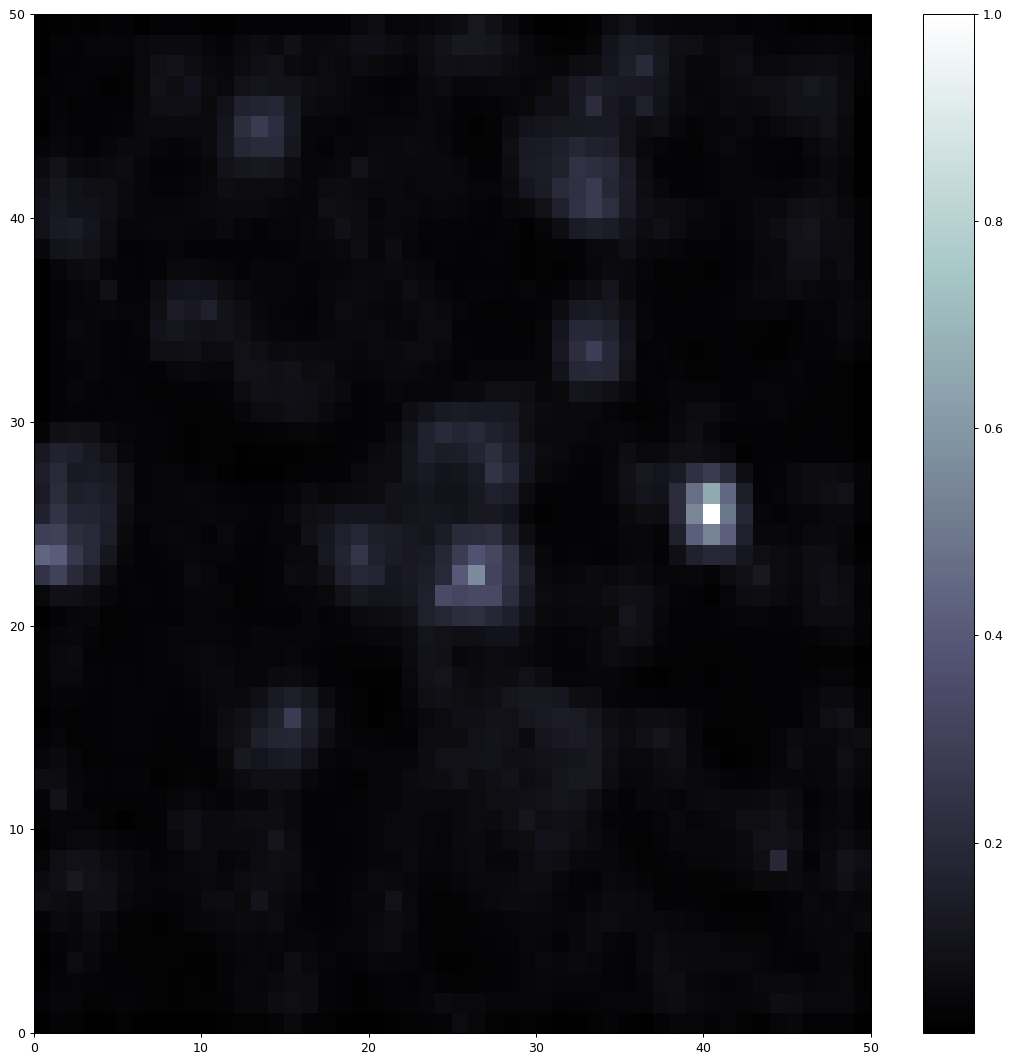

In [35]:
plt.figure(figsize=(15,15),dpi=90)
from pylab import plot, axis, show, pcolor, colorbar, bone
bone()
pcolor(som.distance_map().T) # Distance map as background
colorbar()
show()

Better yet, we can visuallize the clustering by super-imposing the target variables we defined. This is done solely to see how the spatial distribution of input variables were clustered in the final output layer of the network. What is the most interesting about this algorithm is the ability to preserve the topology of the input data set to that of the output neural network.

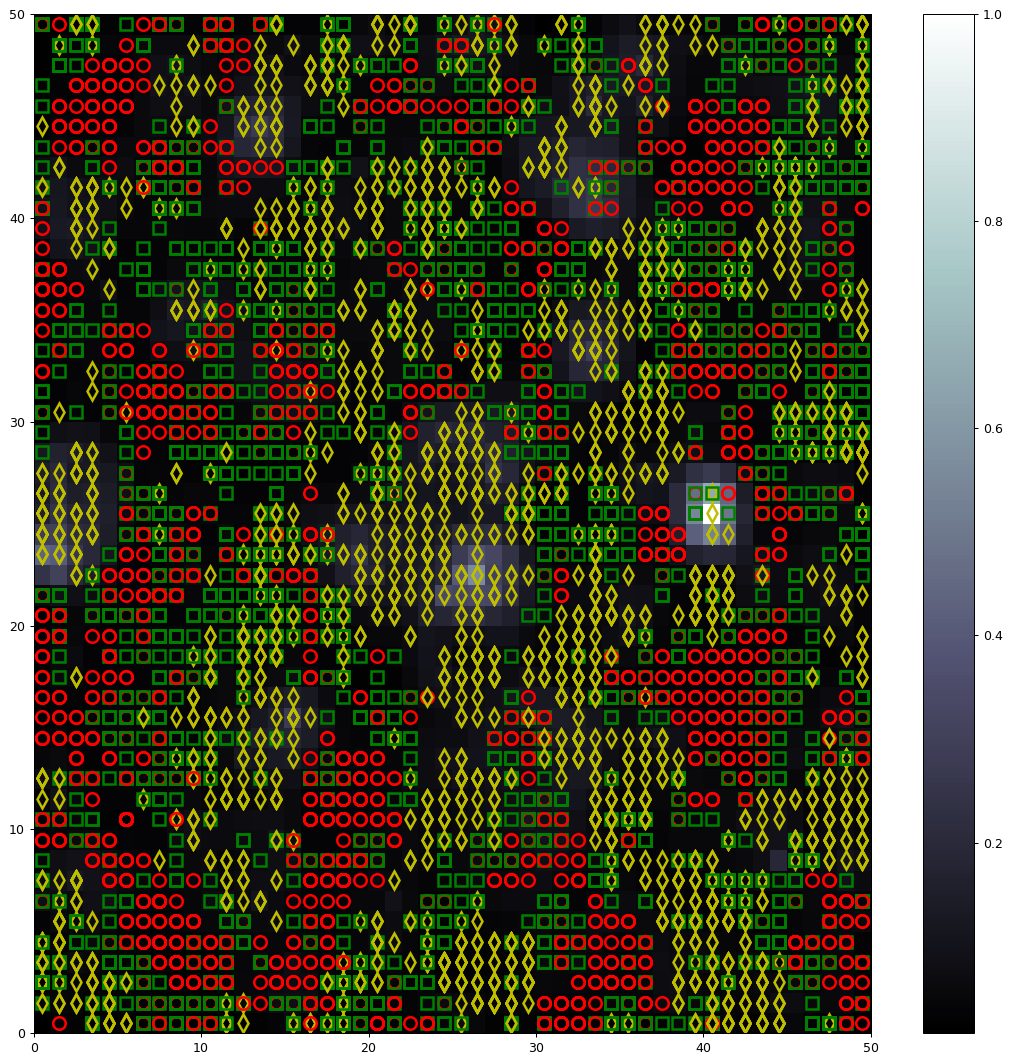

In [36]:
plt.figure(figsize=(15,15),dpi=90)
bone()
pcolor(som.distance_map().T)
colorbar() #gives legend

markers = ['o', 's','d']                     # if the observation is fraud then red circular color or else green square
colors = ['r', 'g','y']
for i, x in enumerate(X):
    
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

# K-Means model

K-Means Clustering is a widely known clustering algorithm. Clusters are assigned to minimize the variance within each cluster. Scikit-Learn will be used to perform the K-Means Clustering. 

The model parameters are described in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).


# Import Data Again

In [37]:
gdf = gpd.read_file('GreaterMTL_DAs.shp')

# Ensure that the columns have the long form name 
gdf.columns = ['DAUID', 'DGUID', 'LANDAREA', 'PRUID', 'aggregationMethod',
       'HasData', 'ORIGINAL_OID', 'sourceCountry',
       '2021 HHs Exp:Tot Expenditure', '2021 Health Care',
       '2021 HHs Exp:Tot Cur Consumptn', '2021 Male Median Age',
       '2021 Total Pop Median Age', '2021 Female Median Age',
       '2021 Total Population', '2026 Total Population',
       '2021 Daytime Pop Total Pop', '2016 HH Type - Total HHs (Census)',
       '2021 HH Type: Total Family HHs', '2026 HH Type: Total Family HHs',
       '2021 Tenure: Total HHs', '2021 Tenure: Owned',
       '2021 Tenure: Owned: Percent', '2021 Tenure: Rented',
       '2021 Tenure: Rented: Percent', '2021 Edu 15+ Above Bachelor',
       '2021 Edu 15+ Above Bachelor: Percent', '2021 Edu 15+ < Bachelor',
       '2021 Edu 15+ < Bachelor: Percent', '2021 Edu 15+ College Dipl',
       '2021 Edu 15+ College Dipl: Percent', '2021 Labour Force HH Pop 15+',
       '2021 Not In the Labour Force', '2021 Not In the Labour Force: Percent',
       '2021 Occ: HH Pop 15+', '2021 Pop Married or Common-Law',
       '2021 Pop Married or Common-Law: Percent', '2021 Pop Living Common Law',
       '2021 Pop Living Common Law: Percent',
       '2021 Pop Single (Never Married)',
       '2021 Pop Single (Never Married): Percent', '2021 OL: English Only',
       '2021 OL: English Only: Percent', '2021 MT: English',
       '2021 MT: English: Percent', '2021 MT: French',
       '2021 MT: French: Percent', '2021 Total PRIZM HHs',
       '2021 Total PRIZM POP', '2021 Dom PRIZM Number',
       '2021 Total Population.1', '2021 Daytime Pop Total Pop.1',
       '2021 HH Inc: Median Curr$', '2021 Transportation',
       '2021 Transportation: Percent', '2021 Tot Charitable Contrib',
       '2021 Goods/Svcs: Internet', '2021 Lawn/Snow/Garbage Removal',
       '2021 Pet Expenses', '2021 Food Purch From Restaurants',
       '2021 Food Purch From Stores', 'Shape_Length', 'Shape_Area', 'Geometry']

# Variables of interest:
predictors = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]

# Replace zero values with null values
gdf[predictors] = gdf[predictors].replace(0, np.nan)
# Fill null values with mean values of each column
gdf[predictors] = gdf[predictors].apply(lambda x: x.fillna(x.mean()), axis=0)

# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = scaler.fit_transform(gdf[predictors])

pd.DataFrame(data_scaled, columns = ['2021 MT: French: Percent',
          '2021 Goods/Svcs: Internet',
          '2021 Pet Expenses',
          '2021 Food Purch From Stores',
          '2021 Food Purch From Restaurants',
          '2021 OL: English Only',
          '2021 Pop Married or Common-Law',
          '2021 Edu 15+ College Dipl',
          '2021 Tenure: Owned',
          '2021 Tenure: Rented',
          '2021 Total Pop Median Age',
          '2021 HH Inc: Median Curr$',
          '2021 Lawn/Snow/Garbage Removal',
          '2021 Tot Charitable Contrib',
          '2021 Not In the Labour Force'
          ]).describe()

,2021 MT: French: Percent,2021 Goods/Svcs: Internet,2021 Pet Expenses,2021 Food Purch From Stores,2021 Food Purch From Restaurants,2021 OL: English Only,2021 Pop Married or Common-Law,2021 Edu 15+ College Dipl,2021 Tenure: Owned,2021 Tenure: Rented,2021 Total Pop Median Age,2021 HH Inc: Median Curr$,2021 Lawn/Snow/Garbage Removal,2021 Tot Charitable Contrib,2021 Not In the Labour Force
count,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00,6588.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.50,-0.81,-0.95,-1.29,-1.10,-0.67,-1.35,-1.39,-1.09,-1.19,-3.71,-1.63,-0.57,-0.30,-1.52
25%,-0.84,-0.48,-0.50,-0.46,-0.46,-0.57,-0.45,-0.53,-0.54,-0.74,-0.66,-0.68,-0.49,-0.22,-0.52
50%,0.24,-0.25,-0.25,-0.26,-0.26,-0.31,-0.23,-0.21,-0.17,-0.01,-0.07,-0.23,-0.27,-0.18,-0.20
75%,0.89,0.10,0.12,0.07,0.09,0.08,0.08,0.18,0.16,0.41,0.50,0.40,0.11,-0.07,0.21
max,1.37,18.05,15.75,16.44,18.76,20.29,13.89,14.69,13.46,12.57,6.25,5.38,37.30,39.34,23.36


### K-Means using Sturge's Rule

We will use 30 clusters, or k=30, as was determined using Sturge's Rule.

In [38]:
from sklearn.cluster import KMeans

In [39]:
# define the model and fit on scaled data
kmeans = KMeans(n_clusters = bins, init = 'k-means++')

In [40]:
# fit the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=30)

In [41]:
pred = kmeans.predict(data_scaled)

In [42]:
pred.shape

(6588,)

In [43]:
data_scaled.shape

(6588, 15)

#### Model quality

In [44]:
kmeans.inertia_

21398.594833589123

Inertia describes how well data was clustered by K-Means. A good model is one with both low inertia and a low number of clusters. 

#### Cluster Size Ratio

Let's first examine the distribution of Dissemination Areas within the 30 clusters. 

In [45]:
data_scaled = pd.DataFrame(data_scaled, columns= ['2021 MT: French: Percent','2021 Goods/Svcs: Internet','2021 Pet Expenses','2021 Food Purch From Stores','2021 Food Purch From Restaurants','2021 OL: English Only','2021 Pop Married or Common-Law','2021 Edu 15+ College Dipl','2021 Tenure: Owned','2021 Tenure: Rented','2021 Total Pop Median Age','2021 HH Inc: Median Curr$','2021 Lawn/Snow/Garbage Removal','2021 Tot Charitable Contrib','2021 Not In the Labour Force'])

In [46]:
data_scaled['Cluster'] = pred

The table below shows the counts within each cluster.

In [47]:
# Counts of Dissemination Areas in each cluster
cluster_counts = pd.DataFrame(data_scaled['Cluster'].value_counts().sort_index().rename_axis('Cluster #').reset_index(name='Counts'))
cluster_counts.transpose()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Cluster #,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Counts,236,855,14,681,563,15,14,27,119,775,81,976,6,249,1,325,40,610,40,38,115,404,138,7,3,42,10,179,2,23


The plot below shows the above table of counts within clusters, visualized as a bar chart.

[Text(0.5, 1.0, 'Counts of Each Cluster Derived From K-Means')]

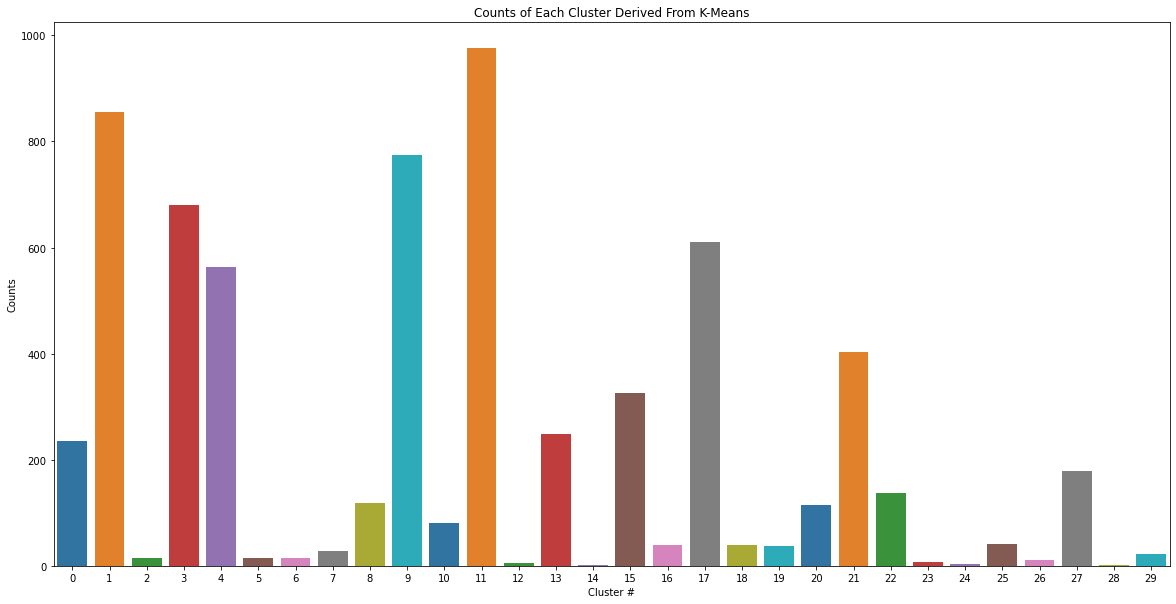

In [48]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Cluster #', y='Counts', data=cluster_counts, palette= "tab10").set(title='Counts of Each Cluster Derived From K-Means')

In [49]:
largest_cluster = cluster_counts['Counts'].max()
largest_cluster

976

In [50]:
smallest_cluster = cluster_counts['Counts'].min()
smallest_cluster

1

#### Smallest/Largest Cluster Ratio

In [51]:
smallest_cluster / largest_cluster

0.0010245901639344263

#### Feature Importance
The below table shows the correlation of each feature to the clusters labels for k=30.

In [52]:
data_scaled.corr()['Cluster'].iloc[:-1].sort_values(ascending=False)

2021 Food Purch From Stores        0.34
2021 Pet Expenses                  0.34
2021 Edu 15+ College Dipl          0.33
2021 Pop Married or Common-Law     0.33
2021 Tenure: Owned                 0.33
2021 Food Purch From Restaurants   0.31
2021 Not In the Labour Force       0.30
2021 Lawn/Snow/Garbage Removal     0.26
2021 HH Inc: Median Curr$          0.24
2021 Goods/Svcs: Internet          0.23
2021 MT: French: Percent           0.14
2021 Tot Charitable Contrib        0.11
2021 Total Pop Median Age          0.09
2021 Tenure: Rented                0.08
2021 OL: English Only              0.02
Name: Cluster, dtype: float64

The below plot shows the correlation of each feature to the cluster labels for k=30, visualized as a bar chart.

<AxesSubplot:>

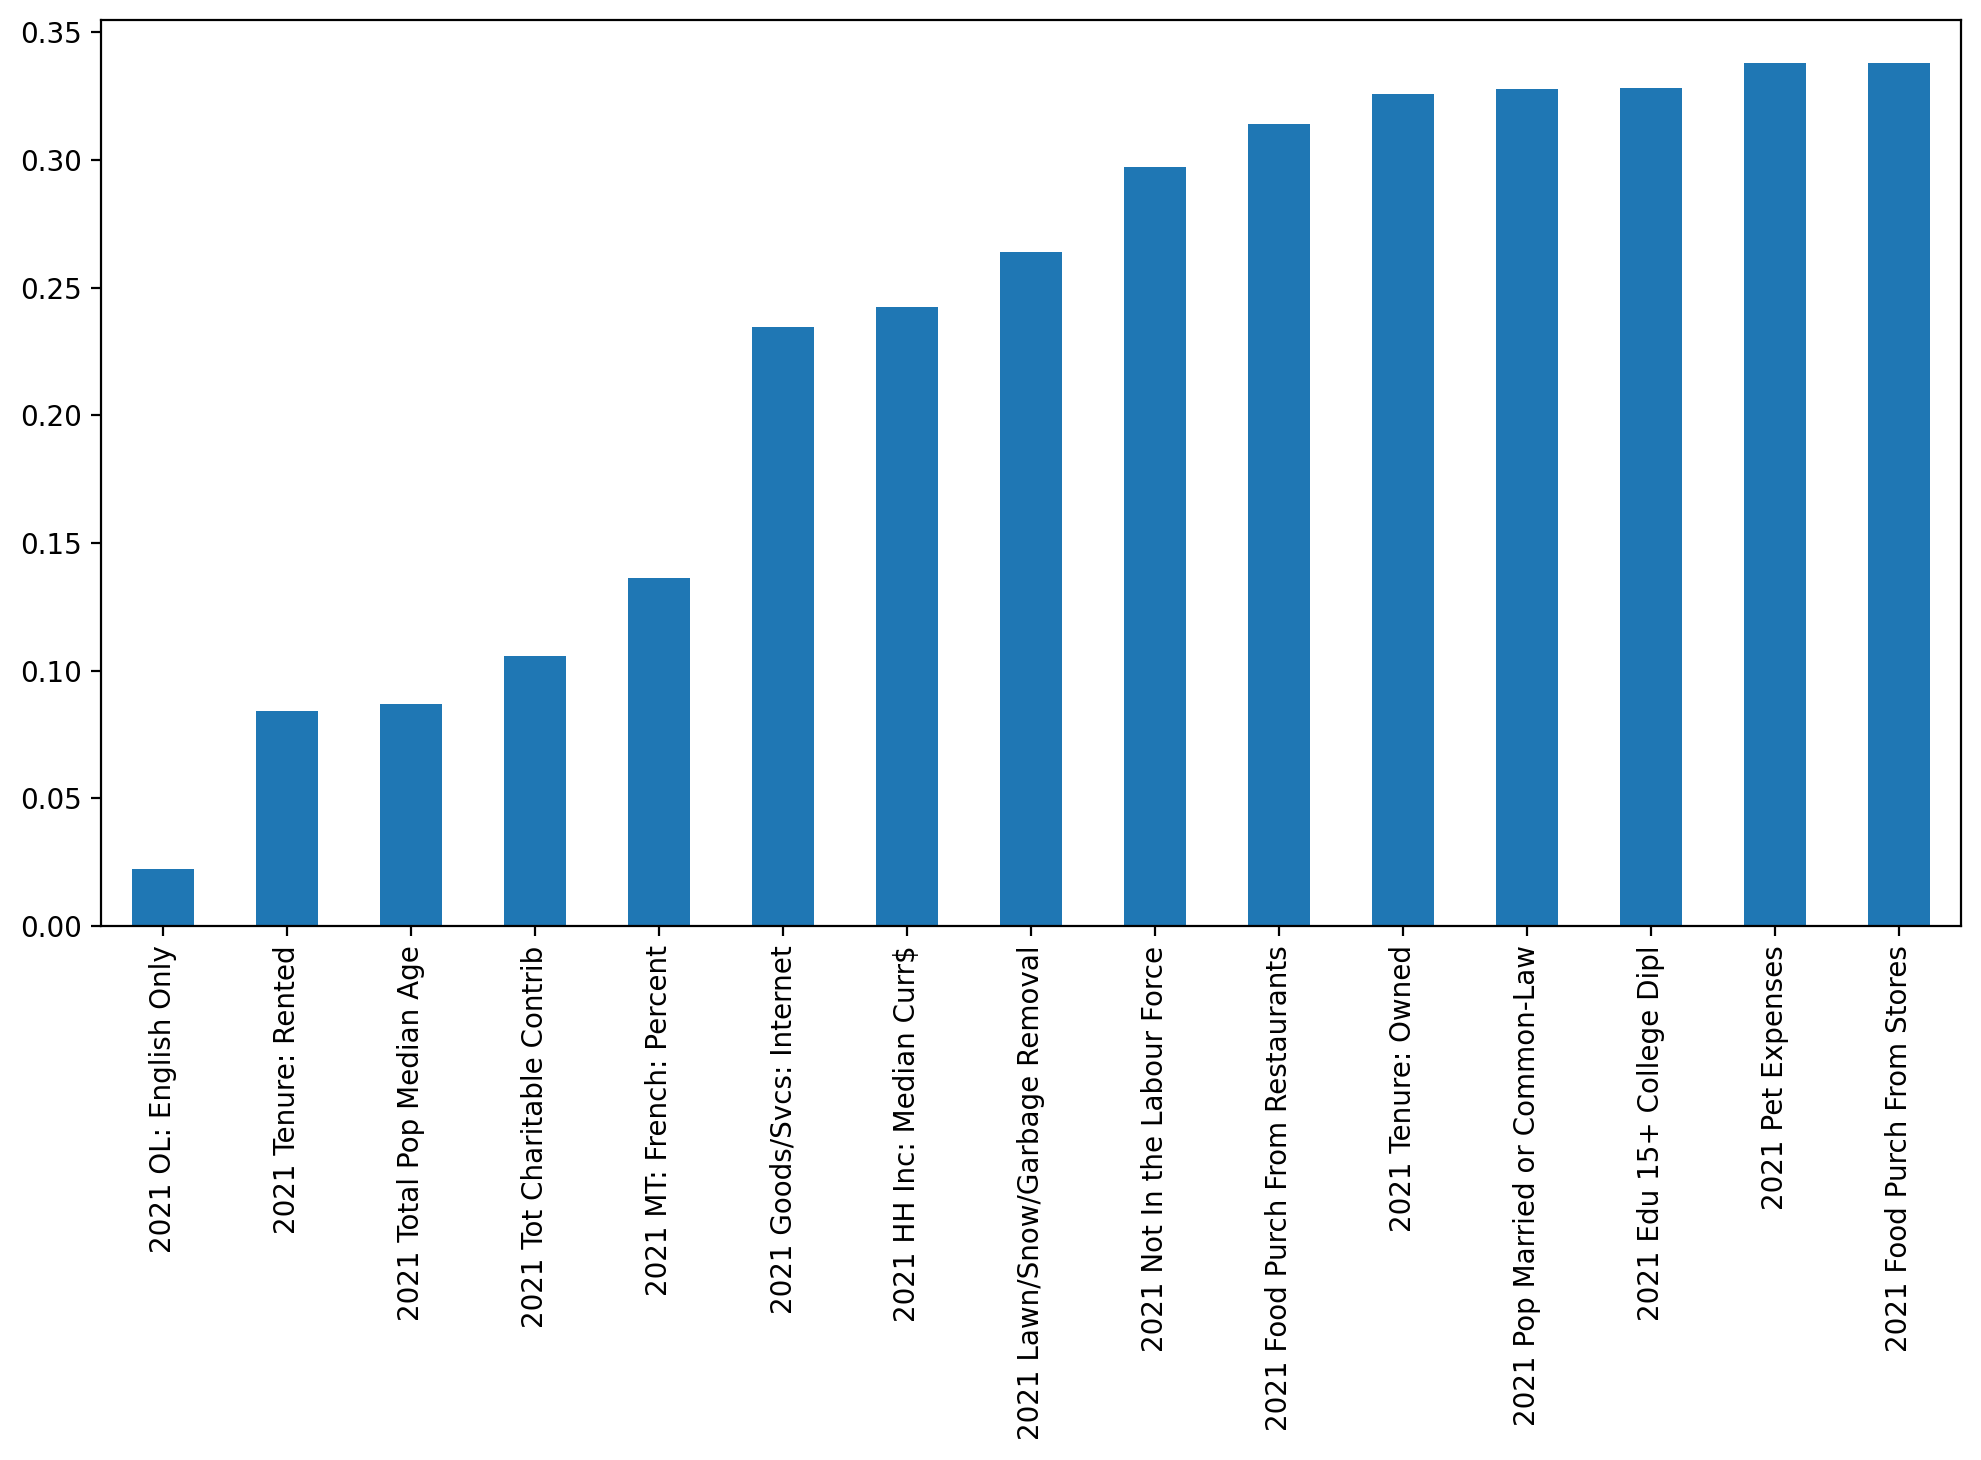

In [53]:
plt.figure(figsize=(12,6),dpi=200)
data_scaled.corr()['Cluster'].iloc[:-1].sort_values().plot(kind='bar')

### Map of Clusters Derived Through K-Means
The 30 clusters are mapped here.

In [54]:
# Merge Predictions and Clusters with Geometry column
data_scaled = gpd.GeoDataFrame(data_scaled, crs='EPSG:3347', geometry=gdf['Geometry'])

Text(0.5, 1.0, 'Distribution of K-Means Clusters for Standardized Data in Greater Montreal')

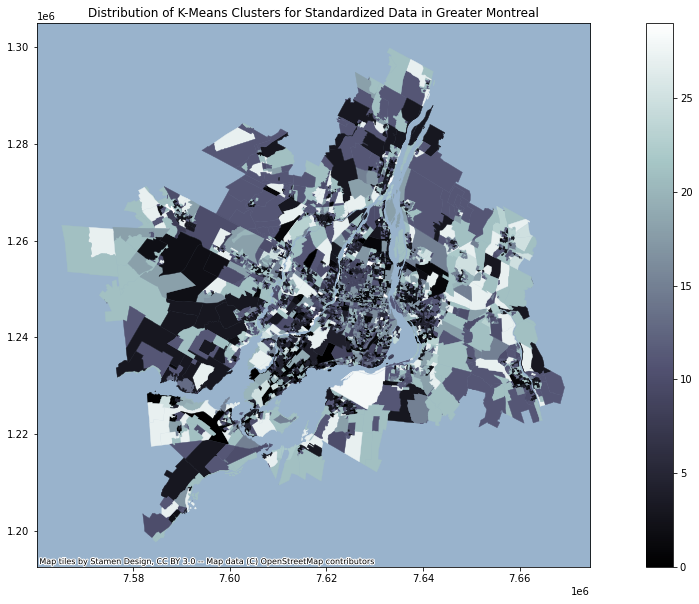

In [55]:
gdf_wm = data_scaled.to_crs(epsg=3857)
ax = data_scaled.plot('Cluster', figsize=(20,10), legend=True, edgecolor="face", linewidth=0.4)
cx.add_basemap(ax)
ax.set_title('Distribution of K-Means Clusters for Standardized Data in Greater Montreal')

### K-Means: Finding Optimal K
Instead of using Sturge's rule, let's now instead use the Elbow method to determine the value of k. The Elbow method is used to determine the point where the decrease in inertia starts to slow (the "elbow" of a graph"). We will compare the number of clusters, or k-value, to the inertia score, or Sum of Squared Distances.

In [57]:
# Start by resetting our input data
# This is what was throwing the error before
data_scaled = scaler.fit_transform(gdf[predictors])

Text(0, 0.5, 'Inertia (Sum of Squared Distances)')

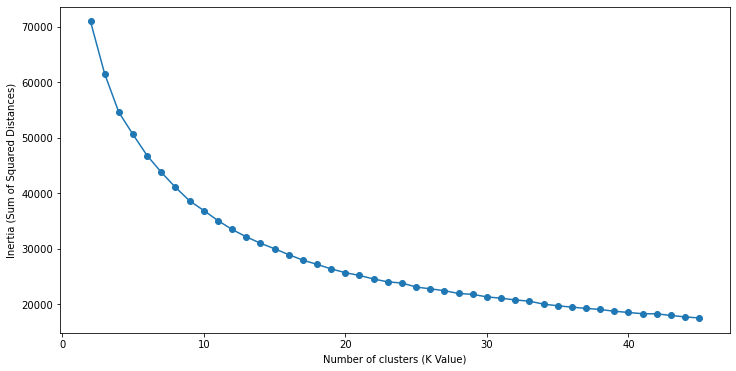

In [58]:
# fitting multiple k-means algorithms and storing inertia values in list
# we will test the range of clusters on either side of 30, as determined by Sturge's Rule
SSD = []
for cluster in range(2,46):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSD.append(kmeans.inertia_)
    
# potting results
frame = pd.DataFrame({'Cluster':range(2,46), 'SSD':SSD})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSD'], marker='o')
plt.xlabel('Number of clusters (K Value)')
plt.ylabel('Inertia (Sum of Squared Distances)')

There is no 100% correct answer as to which K Value is optimal. We are looking for the point at which an increase in k does not result in a significant decrease in SSD. We can examine the values for more detail. 

In [59]:
print(SSD)

[70925.38643089861, 61490.34396349557, 54561.37861844053, 50571.65884080479, 46758.83638195335, 43760.88957060775, 41043.11953857286, 38604.36616260934, 36865.77029169421, 35051.239560595306, 33450.727402011784, 32128.07663934194, 30971.61934801448, 29977.755272338974, 28914.835899957176, 27928.25647761336, 27163.43906146069, 26338.300194676434, 25666.465125233517, 25162.108352923555, 24528.387353538335, 24004.298390439282, 23796.646400362268, 23077.605084141665, 22752.634914514685, 22418.25577421134, 21919.357819123186, 21754.606793547264, 21300.903934508093, 21063.549395779286, 20753.439698164068, 20528.93742011208, 19997.28491252417, 19700.433669800983, 19451.91636905622, 19231.61853611972, 19035.453073422847, 18712.48966203641, 18497.82257234075, 18265.33101709324, 18251.43419141923, 17949.052666550444, 17696.38887693387, 17502.059354302597]


Below we examine the difference between the current inertia or SSD value, and the previous value. This helps us understand the change in inertia. 

In [60]:
pd.Series(SSD).diff()

0         NaN
1    -9435.04
2    -6928.97
3    -3989.72
4    -3812.82
5    -2997.95
6    -2717.77
7    -2438.75
8    -1738.60
9    -1814.53
10   -1600.51
11   -1322.65
12   -1156.46
13    -993.86
14   -1062.92
15    -986.58
16    -764.82
17    -825.14
18    -671.84
19    -504.36
20    -633.72
21    -524.09
22    -207.65
23    -719.04
24    -324.97
25    -334.38
26    -498.90
27    -164.75
28    -453.70
29    -237.35
30    -310.11
31    -224.50
32    -531.65
33    -296.85
34    -248.52
35    -220.30
36    -196.17
37    -322.96
38    -214.67
39    -232.49
40     -13.90
41    -302.38
42    -252.66
43    -194.33
dtype: float64

The argument could be made for a number of different k values depending on the use case. Part of the selection of the optimal k value involves the application of domain knowledge. It appears that we have somewhat of an elbow at k=14, so we will fit a model using this value and plot the results. 

### K-Means Using K=14

In [61]:
# define the model and fit on scaled data
kmeans = KMeans(n_clusters = 14, init = 'k-means++')

In [62]:
data_scaled_newdf = data_scaled[:-1]

In [63]:
cluster_labels = kmeans.fit_predict(data_scaled_newdf)

#### Model Quality

In [64]:
kmeans.inertia_

30827.6290160405

#### Cluster Size Ratio

Let's first examine the distribution of Dissemination Areas within the 14 clusters. 

In [65]:
data_scaled_newdf = pd.DataFrame(data_scaled_newdf, columns= ['2021 MT: French: Percent','2021 Goods/Svcs: Internet','2021 Pet Expenses','2021 Food Purch From Stores','2021 Food Purch From Restaurants','2021 OL: English Only','2021 Pop Married or Common-Law','2021 Edu 15+ College Dipl','2021 Tenure: Owned','2021 Tenure: Rented','2021 Total Pop Median Age','2021 HH Inc: Median Curr$','2021 Lawn/Snow/Garbage Removal','2021 Tot Charitable Contrib','2021 Not In the Labour Force'])

In [66]:
data_scaled_newdf['Cluster'] = cluster_labels

The table below shows the counts within each cluster.

In [67]:
# Counts of Dissemination Areas in each cluster
cluster_counts = pd.DataFrame(data_scaled_newdf['Cluster'].value_counts().sort_index().rename_axis('Cluster #').reset_index(name='Counts'))
cluster_counts.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Cluster #,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Counts,277,52,1028,1813,12,28,88,571,250,1759,1,441,23,244


The plot below shows the above table of counts within clusters, visualized as a bar chart.

[Text(0.5, 1.0, 'Counts of Each Cluster Derived From K-Means')]

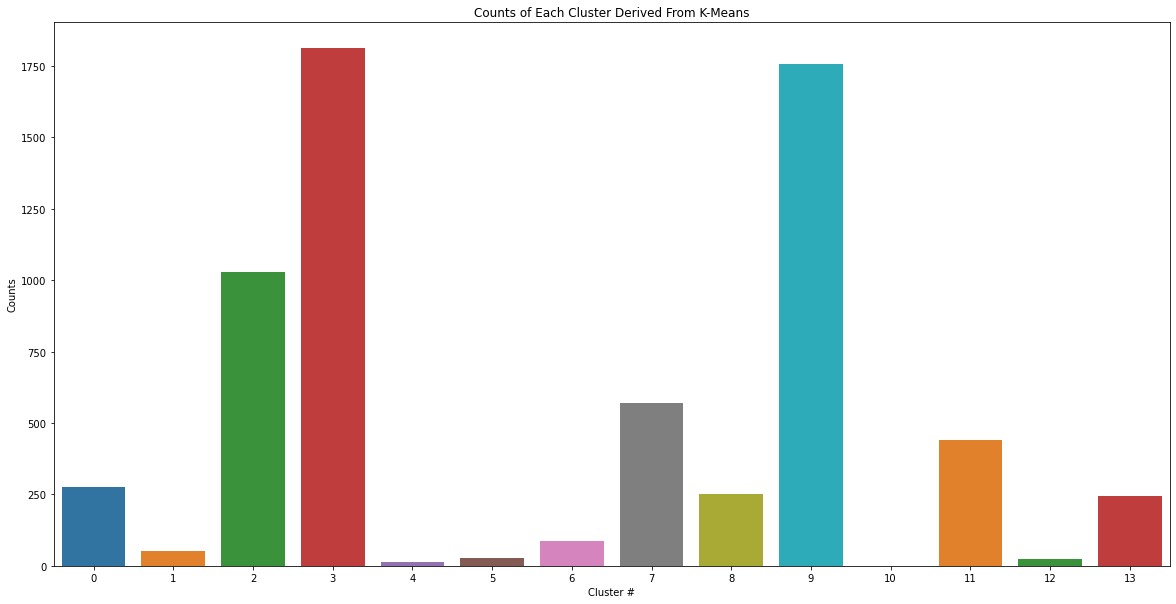

In [68]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Cluster #', y='Counts', data=cluster_counts, palette= "tab10").set(title='Counts of Each Cluster Derived From K-Means')

#### Smallest/Largest Cluster Ratio

In [69]:
largest_cluster = cluster_counts['Counts'].max()
largest_cluster

1813

In [70]:
smallest_cluster = cluster_counts['Counts'].min()
smallest_cluster

1

In [71]:
smallest_cluster / largest_cluster

0.0005515719801434088

The cluster ratio for k=14 is smaller than the ratio for k=30.

#### Feature Importance
The below table shows the correlation of each feature to the clusters labels for k=14.

In [72]:
data_scaled_newdf.corr()['Cluster'].iloc[:-1].sort_values(ascending=False)

2021 Tenure: Rented                 0.35
2021 OL: English Only               0.17
2021 Goods/Svcs: Internet           0.16
2021 Food Purch From Restaurants    0.14
2021 Food Purch From Stores         0.11
2021 Tot Charitable Contrib         0.10
2021 Not In the Labour Force        0.08
2021 Edu 15+ College Dipl           0.07
2021 Pop Married or Common-Law      0.04
2021 Pet Expenses                   0.03
2021 Lawn/Snow/Garbage Removal      0.03
2021 HH Inc: Median Curr$          -0.02
2021 Tenure: Owned                 -0.07
2021 MT: French: Percent           -0.12
2021 Total Pop Median Age          -0.48
Name: Cluster, dtype: float64

The below plot shows the correlation of each feature to the cluster labels for k=14, visualized as a bar chart.

<AxesSubplot:>

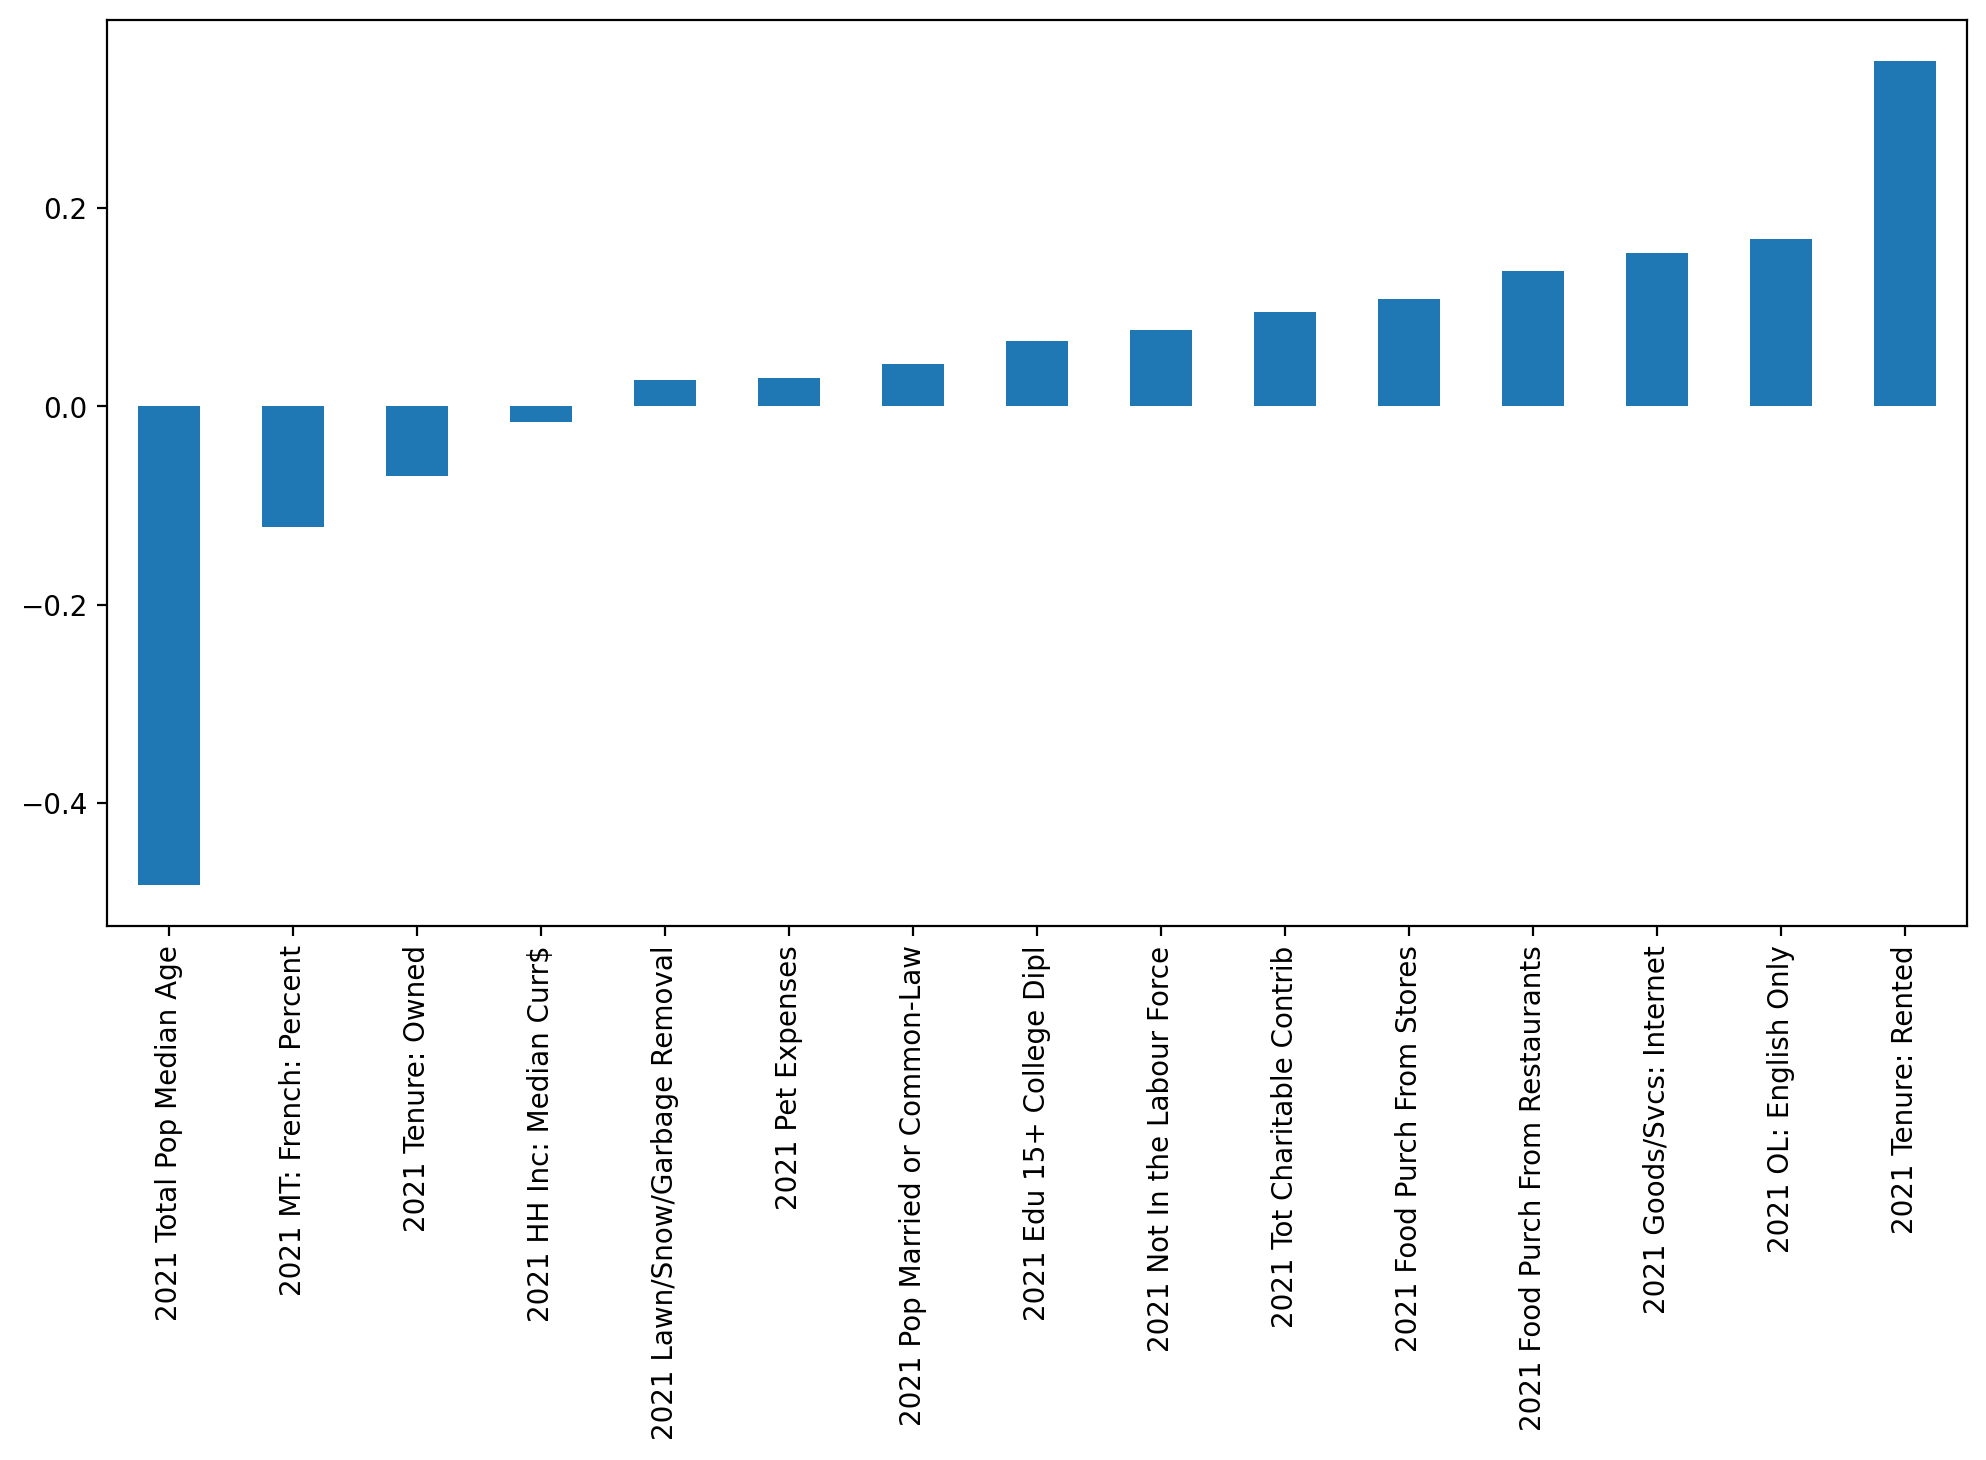

In [73]:
plt.figure(figsize=(12,6),dpi=200)
data_scaled_newdf.corr()['Cluster'].iloc[:-1].sort_values().plot(kind='bar')

### Map of Clusters Derived Through K-Means Using K= 14
The 14 clusters are mapped here.

In [74]:
# Merge Predictions and Clusters with Geometry column
data_scaled2 = gpd.GeoDataFrame(data_scaled_newdf, crs='EPSG:3347', geometry=gdf['Geometry'])

Text(0.5, 1.0, 'Distribution of K-Means Clusters for Standardized Data in Greater Montreal')

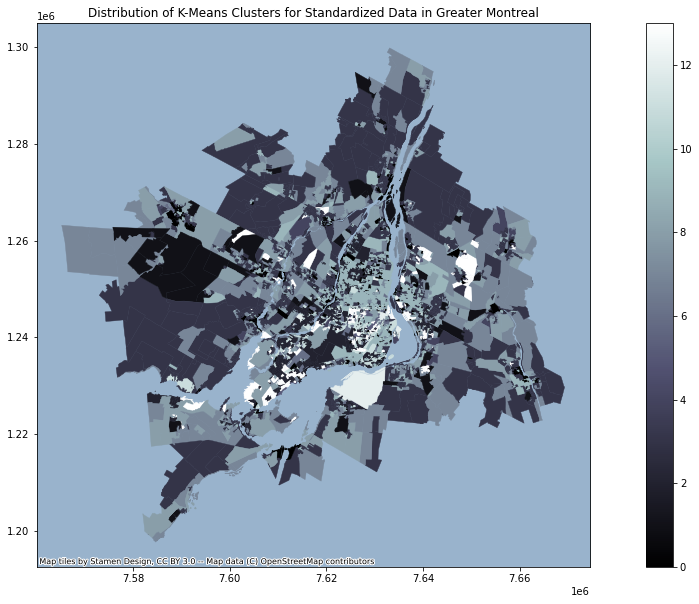

In [75]:
gdf_wm = data_scaled2.to_crs(epsg=3857)
ax = data_scaled2.plot('Cluster', figsize=(20,10), legend=True, edgecolor="face", linewidth=0.4)
cx.add_basemap(ax)
ax.set_title('Distribution of K-Means Clusters for Standardized Data in Greater Montreal')

## K-Means: Conclusions

While Sturge's rule provided a number that certainly could be argued as the optimal k-value, especially given the results of the Elbow method, the 14 clusters are more visually apparent than 30 clusters when mapped.  

There are trade-offs. While using 14 clusters provides a lower k-value, the inertia score is considerably lower for 30 clusters.

For our use case of wanting to visualize where Single people may be found in the Greater Montreal Area, the more limited amount of clusters provides for more manageable parsing. 